# Lumiata Data Science take-home assignment

## This notebook is structured in two parts
###   - The first portion is exploration of the data
###    - The second portion is where to put your code

# Explore the structure of the data first

<h2>Importing Libraries</h2>

In [149]:
import csv
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import re
from tqdm import tqdm
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.metrics import average_precision_score, precision_recall_curve

## Read in train.txt data

In [150]:
import json
from pprint import pprint

ls = []
with open('train.txt') as f:
    for line in f:
        ls.append(json.loads(line))

## Show structure of each patient json
### (key_name, type_of_value_associated_to_key)

In [151]:
pprint(zip(ls[0].keys(), [type(ls[0][x]) for x in ls[0].keys()]))

## Display patient json

In [152]:
#pprint(ls[0])

## Show 'resources' key

In [153]:
#pprint(ls[0]['resources'])

## Show 'observations' key

In [154]:
#pprint(ls[2]['observations'])

# Fill your code below this line



## 1. Experimental setup/design

<h3>Checking the number of points in the train dataset:</h3>

In [155]:
len(ls)

73597

<b>There are 73597 points in the train set</b>

<h3>Preprocessing the Raw Data:</b>

<h3>Removing the points whose tag_dm2 date is before 01-01-2017. We are basically filtering out the priors in this step:</h3>

In [156]:
ls_without_priors=[]
for i in range(0,len(ls)):
    if ls[i]["tag_dm2"]!="":
        if int(ls[i]["tag_dm2"].split('-')[0])>=2017:
            ls_without_priors.append(ls[i])
    elif ls[i]["tag_dm2"]=="":
        ls_without_priors.append(ls[i])
print(len(ls_without_priors))

73520


<b>After removing the priors we see that there are around 73520 points left.</b>

<h3>Creating a label vector:</h3>

In [194]:
labels=[]
for i in range(0,len(ls_without_priors)):
    if ls_without_priors[i]["tag_dm2"]!="":
        if int(ls_without_priors[i]["tag_dm2"].split('-')[0])>2017:
            labels.append(0)
        elif int(ls_without_priors[i]["tag_dm2"].split('-')[0])==2017:
            labels.append(1)
    elif ls_without_priors[i]["tag_dm2"]=="":
        labels.append(0)
labels=np.array(labels)
print(len(labels))

73520


<b>Now, we have a label vector of size 73520.</b>

<h3>Preprocessing the birthday feature and converting it into age in years:</b>

In [195]:
age=[]
for i in range(len(ls_without_priors)):
    age.append(2017-int(ls_without_priors[i]['bday'].split('-')[0]))
df = pd.DataFrame({'Age':age})
df.head()

,Age
0,58
1,14
2,28
3,60
4,24


<h3>Preprocessing the 'is_male' feature:</h3>

In [159]:
is_male=[]
for i in range(len(ls_without_priors)):
    if ls_without_priors[i]['is_male']==True:
        is_male.append(1)
    elif ls_without_priors[i]['is_male']==False: 
        is_male.append(0)
df['is_male']=is_male

<h3>Preprocessing the Observation feature:</h3>

In [160]:
test_list=[]
test_code=set()
for i in range(len(ls_without_priors)):
    m = ls_without_priors[i]['observations']
    for k in m:
        for x in m[k]:
            test_code.add(x['code'])
            test_list.append(x['code'])
print("Number of unique tests:",len(test_code),"Number of total tests performed for all the people:",len(test_list))

Number of unique tests: 3910 Number of total tests performed for all the people: 4158790


<b>After running the above patch of code, it was foind out that the same test was taken by a person multiple times over a period of time. In order to encode this feature only the most recent observation of every unique test is going to be taken into consideration.</b> 

In [161]:
list_of_tests=[]
for i in range(len(ls_without_priors)):
    test_list=[]
    test_code=set()
    dici={}
    m = ls_without_priors[i]['observations']
    for k in m:
        
        for x in m[k]:
            if x['code'] not in dici:
                k_split=k.split('-')
                k_time_obj=datetime.date(int(k_split[0]),int(k_split[1]),int(k_split[2]))
                dici[x['code']]=[k_time_obj]
            elif x['code'] in dici:
                k_split=k.split('-')
                k_time_obj=datetime.date(int(k_split[0]),int(k_split[1]),int(k_split[2]))
                dici[x['code']]+=[k_time_obj]
    list_of_tests.append(dici)
for i in list_of_tests:
    for j in i:
        a=sorted(i[j])
        i[j]=a[-1]  
new_list_of_tests = [] 
for i in range(len(list_of_tests)):
    test={}
    for key, value in list_of_tests[i].items(): 
       if value in test: 
           test[value].append(key) 
       else: 
           test[value]=[key] 
    new_list_of_tests.append(test)

In [162]:
print(new_list_of_tests[0])

{datetime.date(2014, 11, 13): ['loinc_13457-7', 'loinc_1742-6', 'loinc_1751-7', 'loinc_1759-0', 'loinc_17861-6', 'loinc_1920-8', 'loinc_1975-2', 'loinc_1989-3', 'loinc_2028-9', 'loinc_2075-0', 'loinc_2085-9', 'loinc_2093-3', 'loinc_2160-0', 'loinc_2276-4', 'loinc_2345-7', 'loinc_2498-4', 'loinc_2500-7', 'loinc_2571-8', 'loinc_2823-3', 'loinc_2885-2', 'loinc_2951-2', 'loinc_3016-3', 'loinc_3094-0', 'loinc_33037-3', 'loinc_33914-3', 'loinc_44734-2', 'loinc_6768-6', 'loinc_9830-1'], datetime.date(2014, 5, 21): ['loinc_24111-7', 'loinc_6356-0'], datetime.date(2014, 10, 30): ['loinc_20405-7', 'loinc_21000-5', 'loinc_2514-8', 'loinc_25428-4', 'loinc_26444-0', 'loinc_26449-9', 'loinc_26474-7', 'loinc_26484-6', 'loinc_28539-5', 'loinc_30451-9', 'loinc_32167-9', 'loinc_32623-1', 'loinc_32776-7', 'loinc_33825-1', 'loinc_4544-3', 'loinc_49754-5', 'loinc_5770-3', 'loinc_5778-6', 'loinc_5794-3', 'loinc_5799-2', 'loinc_5802-4', 'loinc_5803-2', 'loinc_5804-0', 'loinc_5811-5', 'loinc_6690-2', 'loinc_7

<b> The above obtained new_list_of_tests contains only the unique tests taken for each person. The test taken on the most recent date has been retained.</b>

<h3>Preprocessing the interpretation feature under observations:</h3>

<b>The interpreation feature of a laboratory test for each observation can take the values 'Abnormal', 'Normal', 'Low', 'High','None' or it may have never been done for a particular person. It makes sense to convert this feature to a Bag of Words Representation:</b>

In [163]:
#Buliding the structure of that vector
test_list=[]
test_code=set()
for i in range(len(ls_without_priors)):
    m = ls_without_priors[i]['observations']
    for k in m:
        
        for x in m[k]:
            test_code.add(x['code'])
            test_list.append(x['code'])
#print(len(test_code), len(test_list))
test_code_vector_structure={}
ct=0
test_value_vector=[]
for i in test_code:
    test_code_vector_structure[i]=ct
    ct+=1
for i in range(len(ls_without_priors)):
    temp=[0 for i in range(3910)]
    for date in new_list_of_tests[i]:
        m=ls_without_priors[i]['observations'][date.strftime('%Y-%m-%d')]
        for dici in m:
            if dici['code'] in new_list_of_tests[i][date]:
                temp[test_code_vector_structure[dici['code']]]=dici['interpretation']
    test_value_vector.append(temp)
#print(len(test_value_vector))
for i in range(len(test_value_vector)):
    for j in range(len(test_value_vector[0])):
        if test_value_vector[i][j]==None:
            test_value_vector[i][j]='Noresult'
        elif test_value_vector[i][j]==0:
            test_value_vector[i][j]='Never'
        elif test_value_vector[i][j]=='L':
            test_value_vector[i][j]='Low'
        elif test_value_vector[i][j]=='H':
            test_value_vector[i][j]='High'
        elif test_value_vector[i][j]=='N':
            test_value_vector[i][j]='Normal'
        elif test_value_vector[i][j]=='A':
            test_value_vector[i][j]='Abnormal'
        else:
            continue
yalla=list(test_code)
df_interpretation=pd.DataFrame(test_value_vector)
df_interpretation.columns=yalla

#Converting to BOW
vectorizer = CountVectorizer()
df_interpretation_bow=pd.DataFrame()
for i in range(len(yalla)):
    t=df_interpretation[yalla[i]].values
    X=vectorizer.fit_transform(t)
    
    l=vectorizer.get_feature_names()
    temp_l=[yalla[i]+'_'+j for j in l]
    df_interpretation_bow[temp_l]=pd.DataFrame.sparse.from_spmatrix(X)
print(len(df_interpretation_bow.columns))

9097


<h3>Preprocessing the Resources Feature</h3>

In [164]:
str_rep_of_resources=[]
for i in range(len(ls_without_priors)):
    m=ls_without_priors[i]['resources']
    temp_s=''
    for j in m:
        temp_s+=' '.join(m[j])
        temp_s+=' '
        temp_s=re.sub(' +', ' ', temp_s)
    str_rep_of_resources.append(temp_s)
str_rep_of_resources[0] 

' cpt_99213 icd9_V85.23 cpt_87210 icd9_789.03 cpt_87591 cpt_87491 icd9_616.10 cpt_73620 cpt_99213 icd10_L84 cpt_11055 cpt_73610 icd9_719.47 cpt_99213 icd10_L57.0 cpt_99213 icd10_L84 cpt_17000 icd9_564.00 cpt_99213 cpt_74000 icd9_V85.1 icd9_789.00 icd10_Z12.31 icd9_V76.12 cpt_77057 cpt_73510 icd9_789.03 cpt_99213 cpt_97140 icd9_719.45 cpt_97110 cpt_97001 cpt_72195 icd9_789.09 cpt_99213 icd9_V85.22 icd9_278.02 icd9_700 cpt_83540 cpt_83550 cpt_80053 cpt_82728 icd9_V72.31 cpt_82306 cpt_77080 cpt_84443 icd9_733.90 cpt_80061 cpt_99213 icd9_789.03 icd9_278.02 cpt_97140 icd9_719.45 cpt_97110 icd9_V76.12 cpt_77057 icd9_733.99 icd9_729.5 cpt_73630 cpt_99213 icd9_703.0 icd10_R30.0 cpt_99213 icd10_J40 cpt_87804 cpt_99213 icd9_727.9 cpt_99213 icd10_F41.1 cpt_99213 icd9_715.97 icd9_796.2 cpt_73590 icd9_719.47 cpt_99213 cpt_L1902 cpt_76856 icd9_789.03 icd9_625.9 cpt_76830 cpt_73721 icd9_719.05 cpt_92133 icd10_H40.003 cpt_92083 icd9_719.45 cpt_97110 cpt_97140 icd9_719.45 cpt_97110 cpt_97140 icd9_719.4

In [165]:
cv = CountVectorizer()
cv_fit=cv.fit_transform(str_rep_of_resources)
resources_freq=cv_fit.toarray()

print(resources_freq.shape)
feature_freq_names=cv.get_feature_names()

(73520, 14805)


<b>We have converted the resorces feature into frequency counts. That is, for every patient we will have the number of times a doctor has performed a specific test/diagnosis.So the length of encoding for each patient would be the total number of unique diagonosis/medications or procedures specified by the doctors.From the above we see that the length of encoding for each patient would be 14805.</b>

<h3>Preprocessing the Value feature under Observations:</h3>

<b>This is a numerical feature and for each of the unique tests we are going to have a value for each patient if he has taken the test</b>

In [166]:
#Buliding the structure of that vector
test_list=[]
test_code=set()
for i in range(len(ls_without_priors)):
    m = ls_without_priors[i]['observations']
    for k in m:
        
        for x in m[k]:
            test_code.add(x['code'])
            test_list.append(x['code'])
print(len(test_code), len(test_list))
test_code_vector_structure={}
ct=0
test_value_vector=[]
for i in test_code:
    test_code_vector_structure[i]=ct
    ct+=1
for i in range(len(ls_without_priors)):
    temp=[0 for i in range(3910)]
    for date in new_list_of_tests[i]:
        m=ls_without_priors[i]['observations'][date.strftime('%Y-%m-%d')]
        for dici in m:
            if dici['code'] in new_list_of_tests[i][date]:
                temp[test_code_vector_structure[dici['code']]]=dici['value']
    test_value_vector.append(temp)
print(len(test_value_vector))
for i in range(len(test_value_vector)):
    for j in range(len(test_value_vector[0])):
        if test_value_vector[i][j]==None:
            test_value_vector[i][j]=0 
def column(matrix, i):
    return [row[i] for row in matrix if row[i]!=0]
dici_non_sparse_feature={}
for j in range(0,3910):
    a=column(test_value_vector,j)
    dici_non_sparse_feature[j]=len(a)
import operator
test_code_list=list(test_code)
sorted_d = sorted(dici_non_sparse_feature.items(), key=operator.itemgetter(1))
non_sparse_features=sorted_d[-50:]
#the above matrix holds the index of the 50 most non-sparse features present
def column_return(matrix, i):
    return [row[i] for row in matrix]
feat_vector=[]
feat_nos=[]
for i in non_sparse_features:
    a=column_return(test_value_vector,i[0])
    feat_nos.append(test_code_list[i[0]])
    feat_vector.append(a)
np_feat_vector=np.array(feat_vector)
np_feat_vector_t=np_feat_vector.T
np_feat_vector_t[0]
print(feat_nos)

3910 4158790
73520
['loinc_26444-0', 'loinc_32623-1', 'loinc_30451-9', 'loinc_26449-9', 'loinc_10834-0', 'loinc_26474-7', 'loinc_26484-6', 'loinc_33037-3', 'loinc_770-8', 'loinc_706-2', 'loinc_713-8', 'loinc_736-9', 'loinc_5905-5', 'loinc_21000-5', 'loinc_9830-1', 'loinc_1759-0', 'loinc_788-0', 'loinc_33914-3', 'loinc_3016-3', 'loinc_704-7', 'loinc_785-6', 'loinc_711-2', 'loinc_731-0', 'loinc_742-7', 'loinc_751-8', 'loinc_13457-7', 'loinc_2093-3', 'loinc_2571-8', 'loinc_2085-9', 'loinc_1751-7', 'loinc_1742-6', 'loinc_1920-8', 'loinc_2885-2', 'loinc_1975-2', 'loinc_6768-6', 'loinc_786-4', 'loinc_787-2', 'loinc_2028-9', 'loinc_2075-0', 'loinc_17861-6', 'loinc_6690-2', 'loinc_2345-7', 'loinc_2823-3', 'loinc_2951-2', 'loinc_777-3', 'loinc_718-7', 'loinc_2160-0', 'loinc_3094-0', 'loinc_789-8', 'loinc_4544-3']


<b>Since this is a numerical feature we are going to have to scale and and here it has been chosen to scale between 0 and 1</b>

In [167]:
min_max_scaler=preprocessing.MinMaxScaler()
np_feat_vector_t_scaled=min_max_scaler.fit_transform(np_feat_vector_t)
df_observation_feature=pd.DataFrame(np_feat_vector_t_scaled)
df_observation_feature.columns=feat_nos

<h1>Exploratory Data Analysis:</h1>

<h3>Checking the distribution of Classes, that is, if we have a balanced dataset or an imbalanced dataset:</h3>

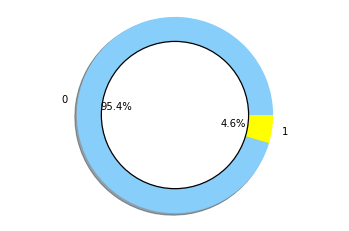

Number of Zeros(Not diagnosed type-2 diabetes in 2017) 70110
Number of Ones(Diagnosed with type-2 diabetes in 2017) 3410


In [168]:
##https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b
##Code to plot the distribution of 2 classes:
no_of_ones=np.count_nonzero(labels)
no_of_zeros=len(labels)-no_of_ones
label = '0', '1'
colors = ['lightskyblue', 'yellow']
classes=[no_of_zeros,no_of_ones]
plt.pie(classes, labels=label, colors=colors,
        autopct='%1.1f%%', shadow=True)
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show() 
print("Number of Zeros(Not diagnosed type-2 diabetes in 2017)",no_of_zeros)
print("Number of Ones(Diagnosed with type-2 diabetes in 2017)",no_of_ones)

<b>We observe that the dataset is highly imbalanced from the above plot. A very large number of people belong to the class with no type-2 diabetes diagnosed in 2017 compared to the number of people who were diagnosed with type-2 diabetes in 2017.</b>

<h3>Checking how the AGE feature which we had engineered previously affects the chance of being affected by type-II diabetes:</h3>

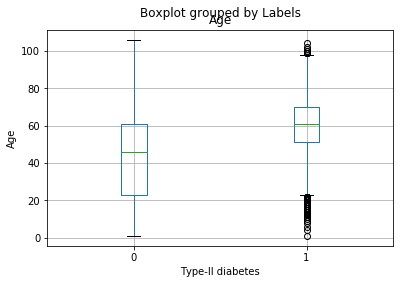

In [200]:
df['Labels']=labels
boxplot = df.boxplot('Age',by='Labels')
boxplot.set_ylabel("Age")
boxplot.set_xlabel("Type-II diabetes")
boxplot

<b>From the above boxplot we observe that the chances of being affected by type-II diabetes varies with age. We say this because the means are completely different so we can make some sort of generalisation from it. For example, we can say that there may be a higher risk of being affected by type-II diabetes if the person if of age>60.</b>

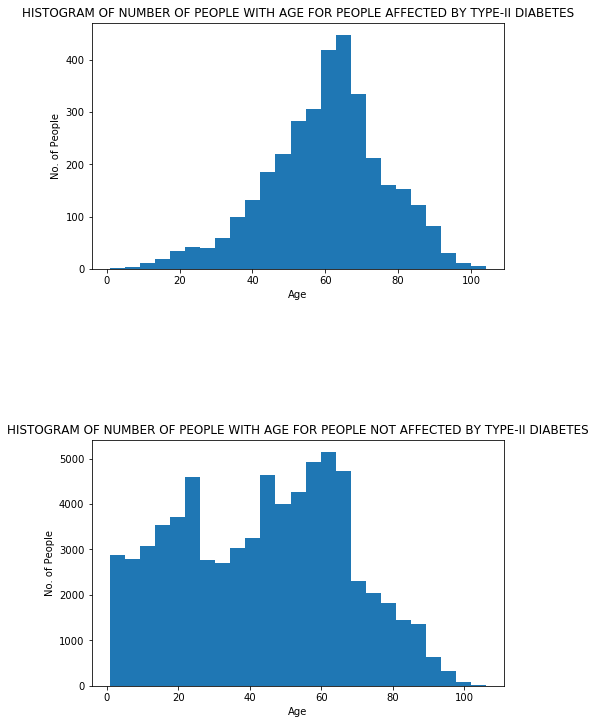

In [170]:
fig, axes = plt.subplots(nrows=2, ncols=1)
ax0, ax1= axes.flatten()
ax0.hist(df[df['Labels']==1]['Age'].values,bins=25)
ax0.set_title('HISTOGRAM OF NUMBER OF PEOPLE WITH AGE FOR PEOPLE AFFECTED BY TYPE-II DIABETES')
ax0.set_xlabel('Age')
ax0.set_ylabel('No. of People')
ax1.hist(df[df['Labels']==0]['Age'].values,bins=25)
ax1.set_title('HISTOGRAM OF NUMBER OF PEOPLE WITH AGE FOR PEOPLE NOT AFFECTED BY TYPE-II DIABETES')
ax1.set_xlabel('Age')
ax1.set_ylabel('No. of People')
fig.tight_layout(pad=1.0)
fig.set_figheight(12)
fig.set_figwidth(15)

<b>Again, from the histogram we can observe a difference in the distribution. Here, it is more evident that people who are aged less than 20 have very less chance of being affected by diabetes.</b>

<b>Conclusion:</b>
    This feature age may be sort of important since it provides a good distinction for people above 60 and people below the age 20.</b>

<h3>Exploring the feature 'is_male':</h3>

<b>We are going to explore here if a person's gender affects the possibility of being affected by Type-II daibetes or not</b>

<h4>Checking number of females diagnosed with diabetes in 2017 and the number of females who weren't diagnosed with diabetes in 2017:</h4>

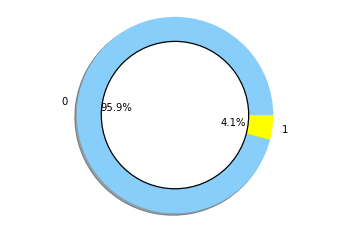

Number of Zeros(Females who were not diagnosed type-2 diabetes in 2017) 38465
Number of Ones(Feales who were diagnosed with type-2 diabetes in 2017) 1624


In [171]:
female_df=df[df['is_male']==0]
female_df['Labels'].value_counts()
##https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b
##Code to plot the distribution of 2 classes:
label = '0', '1'
colors = ['lightskyblue', 'yellow']
classes=[female_df['Labels'].value_counts()[0],female_df['Labels'].value_counts()[1]]
plt.pie(classes, labels=label, colors=colors,
        autopct='%1.1f%%', shadow=True)
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show() 
print("Number of Zeros(Females who were not diagnosed type-2 diabetes in 2017)",female_df['Labels'].value_counts()[0])
print("Number of Ones(Feales who were diagnosed with type-2 diabetes in 2017)",female_df['Labels'].value_counts()[1])

<h4>Checking number of Males diagnosed with diabetes in 2017 and the number of Males who weren't diagnosed with diabetes in 2017:</h4>

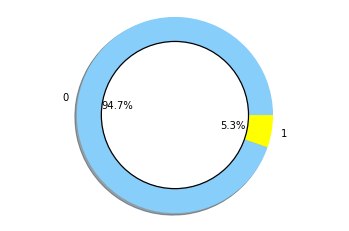

Number of Zeros(Males who were not diagnosed type-2 diabetes in 2017) 31645
Number of Ones(Males who were diagnosed with type-2 diabetes in 2017) 1786


In [172]:
male_df=df[df['is_male']==1]
male_df['Labels'].value_counts()
##https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b
##Code to plot the distribution of 2 classes:

label = '0', '1'
colors = ['lightskyblue', 'yellow']
classes=[male_df['Labels'].value_counts()[0],male_df['Labels'].value_counts()[1]]
plt.pie(classes, labels=label, colors=colors,
        autopct='%1.1f%%', shadow=True)
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show() 
print("Number of Zeros(Males who were not diagnosed type-2 diabetes in 2017)",male_df['Labels'].value_counts()[0])
print("Number of Ones(Males who were diagnosed with type-2 diabetes in 2017)",male_df['Labels'].value_counts()[1])

<b>From the above donut plots,we can say that the gender of the person does not clearly affect the fact that whether he has been diagnosed with diabetes in 2017 or not. This is because the percentages of affected and not affected by diabetes is not changing so much(little more than 1%) with respect to gender.</b>

<h3>Exploring the feature, the number of times a person goes for a medical test:</h3>

<b>This may be a useful feature because generally diabetes patients tend to get the blood test more number of times than people who are not affected by diabetes.</b>

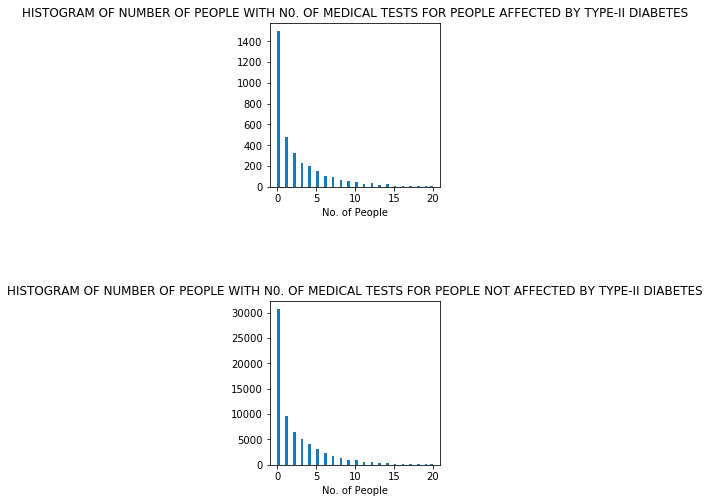

In [173]:
no_of_days_medical_test=[]
for i in range(len(ls_without_priors)):
    no_of_days_medical_test+=[len(ls[i]['observations'])]
df['no_of_days_medical_test']=no_of_days_medical_test
fig, axes = plt.subplots(nrows=2, ncols=1)
ax0, ax1= axes.flatten()
ax0.hist(df[df['Labels']==1]['no_of_days_medical_test'].values,bins=60,range=[0,20])
ax1.hist(df[df['Labels']==0]['no_of_days_medical_test'].values,bins=60,range=[0,20])
ax0.set_title('HISTOGRAM OF NUMBER OF PEOPLE WITH N0. OF MEDICAL TESTS FOR PEOPLE AFFECTED BY TYPE-II DIABETES')
ax0.set_xlabel('No. of medical tests')
ax0.set_xlabel('No. of People')
ax1.set_title('HISTOGRAM OF NUMBER OF PEOPLE WITH N0. OF MEDICAL TESTS FOR PEOPLE NOT AFFECTED BY TYPE-II DIABETES')
ax1.set_xlabel('No. of medical tests')
ax1.set_xlabel('No. of People')
fig.tight_layout(pad=1.0)
fig.set_figheight(8)
fig.set_figwidth(20)

<b> We learn from the above histograms that this feature does not help greatly in distinguishing between the people affected and not affected by diabetes since the distribution somewhat remains the same for both and also the dataset is highly imbalanced.</b>

<h3>Exploring the interpretation of the Lab tests feature:</h3>

<b>This feature has been encoded into Bag of Words format.Hence,we will have a column corresponding to each of the possible observed value for each test. Since,this will be of very high dimensionality, we will only be visualising the most important of these features. That is the feature which has the most correlation with the label. This will be identified using the SelecKBest feature of sklearn.</b>

In [174]:
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(df_interpretation_bow,df['Labels'])
scores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_interpretation_bow.columns)
featureScores = pd.concat([dfcolumns,scores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(100,'Score'))
best_20_features=featureScores.nlargest(100,'Score')['Specs']

                      Specs        Score
3403      loinc_4548-4_high  4747.484130
2008     loinc_27353-2_high  3497.438775
5699      loinc_2345-7_high  1683.673463
5518   loinc_14957-5_normal  1269.742131
8695    loinc_9318-7_normal   893.697679
...                     ...          ...
4356     loinc_1975-2_never    96.240647
7954   loinc_19123-9_normal    96.037637
1838       loinc_1968-7_low    95.149258
8002  loinc_5778-6_noresult    94.224749
7314       loinc_1989-3_low    93.282036

[100 rows x 2 columns]


<b> We can see a pretty high score for the feature 'loinc_4548-4_high'. Lets take a look at how this feature is distributed for both the classes </b>

In [175]:
a_0=df_interpretation_bow[df['Labels']==0]['loinc_4548-4_high'].value_counts()

In [176]:
a_1=df_interpretation_bow[df['Labels']==1]['loinc_4548-4_high'].value_counts()

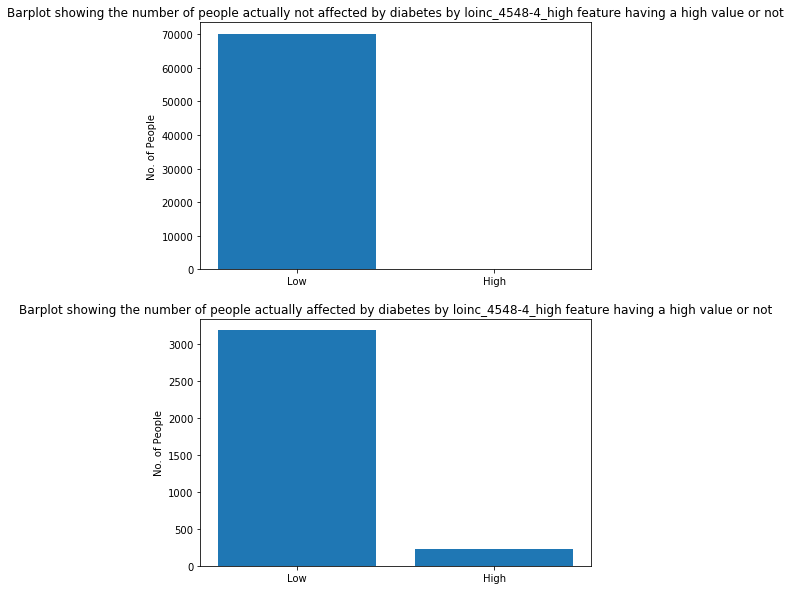

In [177]:
df_interpretation_bow['Labels']=labels
fig, axes = plt.subplots(nrows=2, ncols=1)
ax0, ax1= axes.flatten()
li=[a_0[0],a_0[1]]
l1_1=[a_1[0],a_1[1]]
ax0.bar(['Low','High'],li)

ax0.set_title('Barplot showing the number of people actually not affected by diabetes by loinc_4548-4_high feature having a high value or not')
ax0.set_ylabel('No. of People')
ax1.bar(['Low','High'],l1_1)

ax1.set_title('Barplot showing the number of people actually affected by diabetes by loinc_4548-4_high feature having a high value or not')
ax1.set_ylabel('No. of People')
fig.tight_layout(pad=5.0)
fig.set_figheight(10)
fig.set_figwidth(7)

<b>From the above plots we see that there are about 200 people who are having a low value of 'loinc_4548-4_high' actually have diabetes. This looks less but it is actually an important feature, the reason being we have a very imbalanced dataset here hence we have a small value but this feature will help us tremendously in distinguishing since it acts as a very good identifier for True negatives</b>

<h3>Exploring the Resources feature which contained the medications,diagnosis and procedures performed or described by the Doctor for each patient:</h3

<b>This feature has also been encoded into Bag of Words representation</b>

<b>Since this is also a very large sized vector, we are going to find the feature which is most correlated with the output labels and then visualize it.</b>

In [178]:
df_resources_freq=pd.DataFrame(resources_freq)
bestfeatures_freq = SelectKBest(score_func=chi2, k=10)
fit_freq = bestfeatures_freq.fit(df_resources_freq,df['Labels'])
scores = pd.DataFrame(fit_freq.scores_)
df_feature_freq_names=pd.DataFrame(feature_freq_names)
feature_freq_Scores = pd.concat([df_feature_freq_names,scores],axis=1)
feature_freq_Scores.columns = ['Specs','Score']
print(feature_freq_Scores.nlargest(10,'Score'))


           Specs          Score
12459  icd10_e11  151036.966015
12720  icd10_i10   27299.054325
9701   cpt_99232   17280.828909
12731  icd10_i25   15061.720085
12848  icd10_j96   14041.550226
12505  icd10_e78   13576.758745
12823  icd10_j44   13103.078898
12754  icd10_i50   12957.811643
13090  icd10_n18   10744.907784
8261   cpt_83036   10095.513621


<b>By looking at the scores obtained by using chi-square as the metric we see that the first couple of features may have a good amount of influence on the class.</b>

<b>Now lets visualize how the feature icd10_e11 is distributed for both the classes</b>

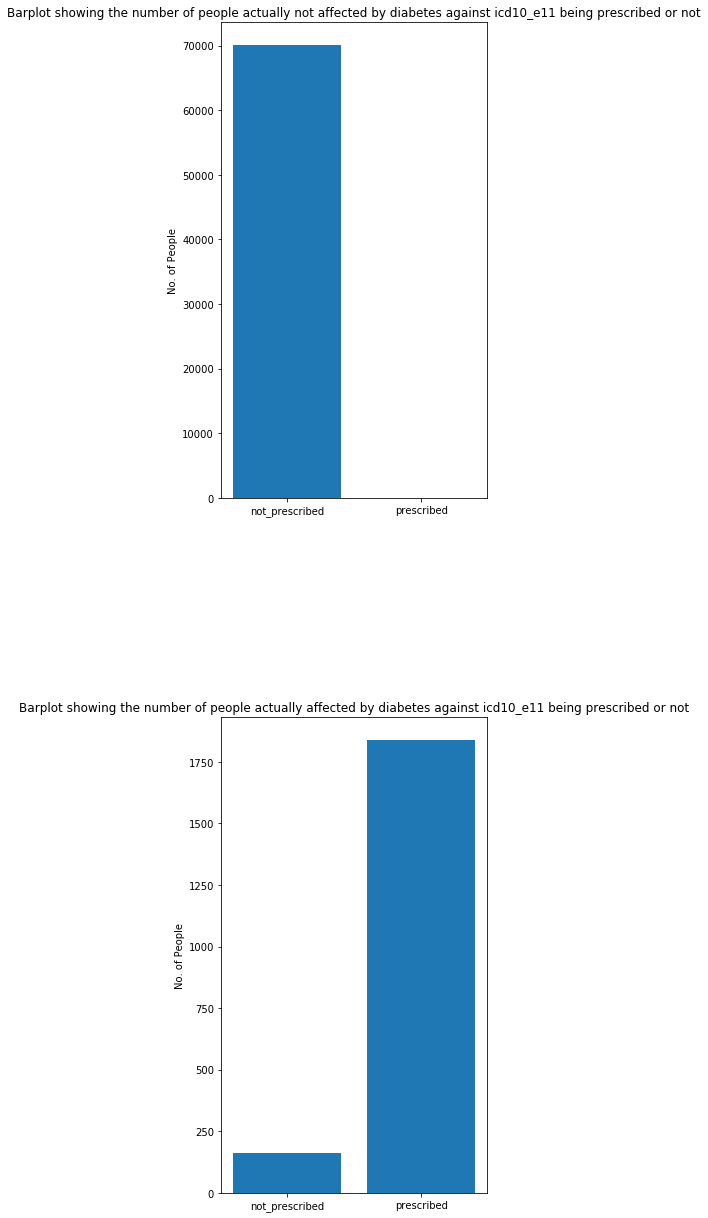

In [197]:
df_resources_freq.columns=feature_freq_names
a_0=df_resources_freq['icd10_e11']
a_0=a_0[df['Labels']==0].value_counts()
a_1=df_resources_freq['icd10_e11']
a_1=a_1[df['Labels']==1].value_counts()
fig, axes = plt.subplots(nrows=2, ncols=1)
ax0, ax1= axes.flatten()
li=[a_0[0],a_0[1]]
l1_1=[a_1[0],a_1[1]]
ax0.bar(['not_prescribed','prescribed'],li)
ax0.set_title('Barplot showing the number of people actually not affected by diabetes against icd10_e11 being prescribed or not')
ax0.set_ylabel('No. of People')
ax1.bar(['not_prescribed','prescribed'],l1_1)
ax1.set_title('Barplot showing the number of people actually affected by diabetes against icd10_e11 being prescribed or not')
ax1.set_ylabel('No. of People')
fig.tight_layout(pad=1.0)
fig.set_figheight(20)
fig.set_figwidth(30)

<b>From the above plots we observe that this seems to be one of the important features and is going to be very important in distinguishing because we can clearly see that there are a very large number of people who been affected by diabetes and been prescribed this icd10_e11 and also there is almost no one who has been not affected by diabetes and been prescribed with this.</b> 

<b>Exploring the icd10_i10 feature</b>

<b>This feature is also bag of words encoded hence we have 0 if this has been prescribed else 1</b>

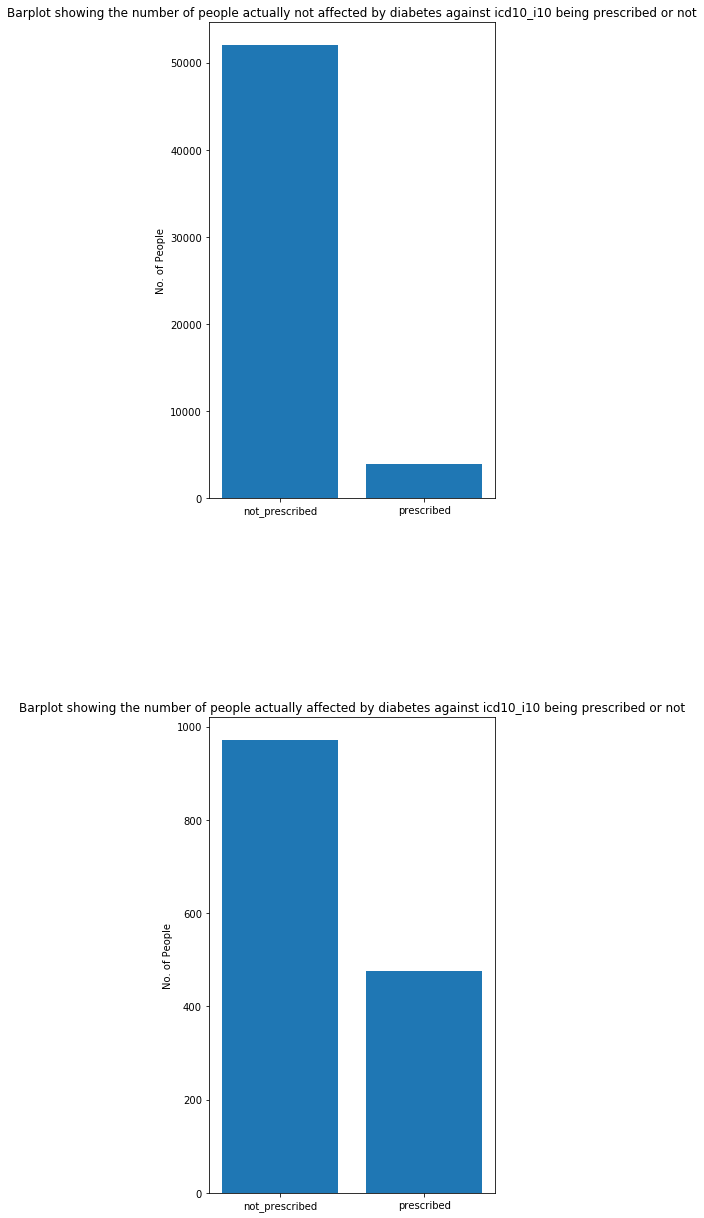

In [198]:
a_0=df_resources_freq['icd10_i10']
a_0=a_0[df['Labels']==0].value_counts()
a_1=df_resources_freq['icd10_i10']
a_1=a_1[df['Labels']==1].value_counts()
fig, axes = plt.subplots(nrows=2, ncols=1)
ax0, ax1= axes.flatten()
li=[a_0[0],a_0[1]]
l1_1=[a_1[0],a_1[1]]
ax0.bar(['not_prescribed','prescribed'],li)
ax0.set_title('Barplot showing the number of people actually not affected by diabetes against icd10_i10 being prescribed or not')
ax0.set_ylabel('No. of People')
ax1.bar(['not_prescribed','prescribed'],l1_1)
ax1.set_title('Barplot showing the number of people actually affected by diabetes against icd10_i10 being prescribed or not')
ax1.set_ylabel('No. of People')
fig.tight_layout(pad=1.0)
fig.set_figheight(20)
fig.set_figwidth(30)

<b>This I believe would also an important feature because we can clearly see that there are a very large number of people who are affected by diabetes who have been prescribed this medication.</b>

<b> Some of the basic features and some engineered features have been explored above. Now lets proceed into the feature design section where we will will select the features we are going to use in our model and also engineer and explore a couple of more features.</b>

## 2. Feature design/feature selection

<h3>-->Some of the important features that we identified above that will be used to model are Age, icd10_e11 , icd10_e10 and loinc_4548-4_high.
Apart from these we will design a few more features</h3>

<h3>Now we are going to engineer another feature which is going to comprise sum of the most important features given by SelectKBest and which were not used in the feature above</b>

In [181]:
diabetes_icd_imp=df_resources_freq[['cpt_99232','icd10_i25','icd10_j96','icd10_e78','icd10_j44','icd10_i50','icd10_n18','cpt_83036']]
diab_feat_imp=diabetes_icd_imp.sum(axis=1)
diab_feat_imp.columns=['sum_of_imp_resources']
#,'cpt_99232','icd10_i25','icd10_j96','icd10_e78','icd10_j44','icd10_i50','icd10_n18','cpt_83036'
'icd10_e08','icd10_e09','icd10_e10','icd10_e11','icd10_e13'

('icd10_e08', 'icd10_e09', 'icd10_e10', 'icd10_e11', 'icd10_e13')

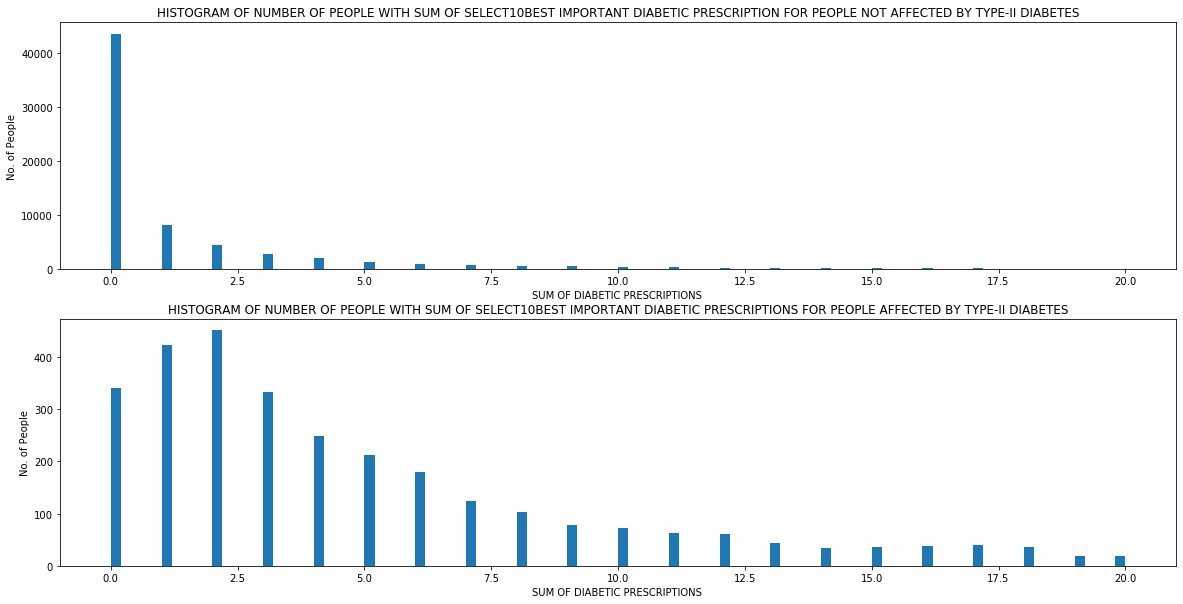

In [182]:
fig, axes = plt.subplots(nrows=2, ncols=1)
ax0, ax1= axes.flatten()
ax0.hist(diab_feat_imp[df['Labels']==0],bins=100,range=[0,20])
ax1.hist(diab_feat_imp[df['Labels']==1],bins=100,range=[0,20])
ax0.set_title('HISTOGRAM OF NUMBER OF PEOPLE WITH SUM OF SELECT10BEST IMPORTANT DIABETIC PRESCRIPTION FOR PEOPLE NOT AFFECTED BY TYPE-II DIABETES')
ax0.set_xlabel('SUM OF DIABETIC PRESCRIPTIONS ')
ax0.set_ylabel('No. of People')
ax1.set_title('HISTOGRAM OF NUMBER OF PEOPLE WITH SUM OF SELECT10BEST IMPORTANT DIABETIC PRESCRIPTIONS FOR PEOPLE AFFECTED BY TYPE-II DIABETES')
ax1.set_xlabel('SUM OF DIABETIC PRESCRIPTIONS ')
ax1.set_ylabel('No. of People')
fig.tight_layout(pad=2.0)
fig.set_figheight(10)
fig.set_figwidth(20)

<B>By looking at the above plot we can say that this definitely becomes another feature that we have to incorportate into our model since it again helps us distinguish between both the classes since the distribututions are different.</b> 

<h2>Since we have decided which features to proceed with, we are going to start to put together these features into one dataframe.</h2>

In [183]:
final_features=pd.concat([df['Age'],df_interpretation_bow['loinc_4548-4_high'],df_resources_freq['icd10_i10'],df_resources_freq['icd10_e11'],diab_feat_imp],axis=1)
final_features.rename(columns={ final_features.columns[4]: "sum_of_imp_resources" }, inplace = True)
print(final_features.head())

   Age  loinc_4548-4_high  icd10_i10  icd10_e11  sum_of_imp_resources
0   58                  0          0          0                     0
1   14                  0          0          0                     0
2   28                  0          0          0                     0
3   60                  0          0          0                    10
4   24                  0          0          0                     1


<b>Since we have an imbalanced dataset we are going to Upsample the dataset.</b>

<h2>Upsampling the dataset using random resampling method</h2>

In [184]:
minority=final_features[df['Labels']==1]
df_minority_upsampled = resample(minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=70110,    # to match majority class
                                 random_state=123)
majority_class=final_features[df['Labels']==0]
labels=[1 for i in range(70110)]
labels.extend([0 for i in range(70110)])
design_matrix=pd.concat([df_minority_upsampled,majority_class])
design_labels=pd.DataFrame(labels)
design_matrix.head()

,Age,loinc_4548-4_high,icd10_i10,icd10_e11,sum_of_imp_resources
28387,57,0,0,3,7
23645,84,0,26,1,52
38006,74,0,11,1,5
67017,55,0,0,0,3
47262,64,0,2,1,6


## 3. Model selection/tuning

<h3>Logistic Regression Model</h3>

<h3>Splitting into train-set(80%) and cross-validation set(20%):</h3>

In [185]:
X_train, X_cv, y_train, y_cv = train_test_split(design_matrix,labels, test_size=0.20, random_state=42)

<h3>Cross-Validation:</h3>

<b>We are going to use cross validation to find the right regularisation parameter. We will use the PRAUC(same as the average precision) as the metric for cross-validation. So we have to seperate our train data now into train and cross-validation set:</b>

In [186]:
train_prauc=[]
cv_prauc=[]
precision_cv=[]
recall_cv=[]
regu_para=[10**-9,10**-8,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2,10**-1,10,10**1,10**2]
for i in tqdm(range(len(regu_para))):
    clf = LogisticRegression(random_state=0,penalty='l2',C=regu_para[i]).fit(X_train,y_train)
    train_probs=clf.predict_proba(X_train)[:,1]
    cv_probs=clf.predict_proba(X_cv)[:,1]
    train_prauc+=[average_precision_score(y_train,train_probs)]
    cv_prauc+=[average_precision_score(y_cv,cv_probs)]
    precision, recall, _ = precision_recall_curve(y_cv,cv_probs)
    precision_cv.append(precision)
    recall_cv.append(recall)




  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:00<00:06,  1.64it/s]

 17%|█▋        | 2/12 [00:01<00:06,  1.62it/s]

 25%|██▌       | 3/12 [00:01<00:05,  1.61it/s]

 33%|███▎      | 4/12 [00:02<00:05,  1.51it/s]

 42%|████▏     | 5/12 [00:03<00:04,  1.41it/s]

 50%|█████     | 6/12 [00:04<00:04,  1.32it/s]

 58%|█████▊    | 7/12 [00:05<00:04,  1.18it/s]

 67%|██████▋   | 8/12 [00:06<00:03,  1.09it/s]

 75%|███████▌  | 9/12 [00:07<00:02,  1.05it/s]

 83%|████████▎ | 10/12 [00:08<00:02,  1.12s/it]

 92%|█████████▏| 11/12 [00:10<00:01,  1.23s/it]

100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


<b>We are going to plot the precision-recall curve for all the values of regularisation parameter</b>

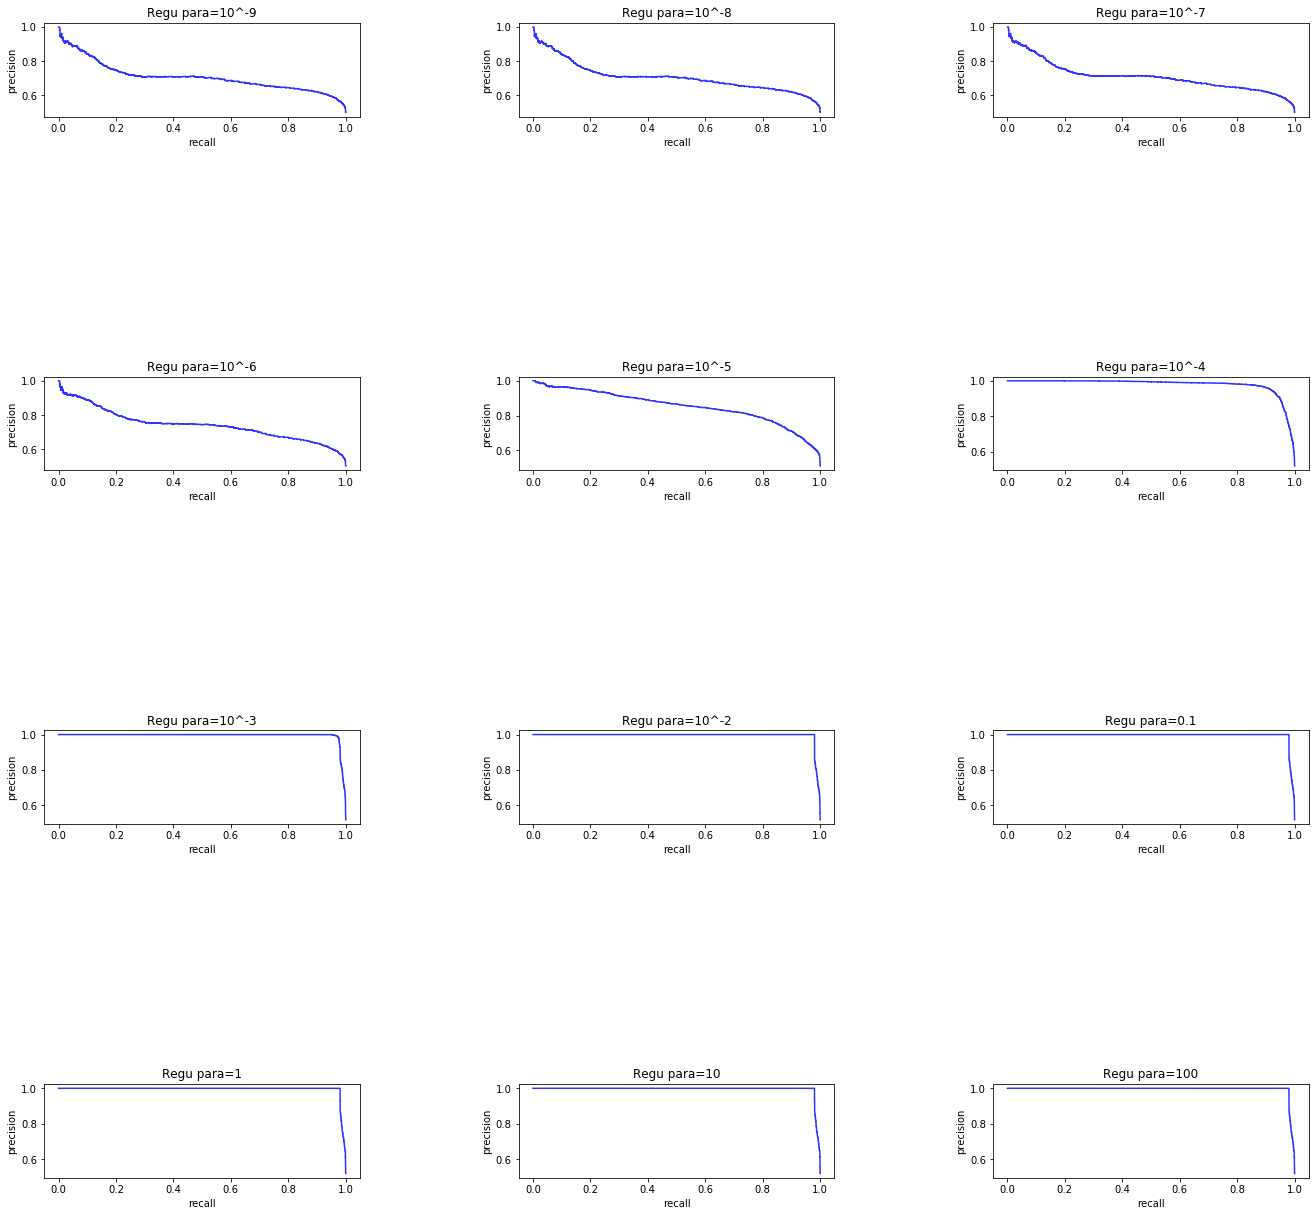

In [199]:
fig, axes = plt.subplots(nrows=4, ncols=3)
ax0, ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11= axes.flatten()
ax0.step(recall_cv[0], precision_cv[0], color='b', alpha=0.8,where='post')
ax1.step(recall_cv[1], precision_cv[1], color='b', alpha=0.8,where='post')
ax2.step(recall_cv[2], precision_cv[2], color='b', alpha=0.8,where='post')
ax3.step(recall_cv[3], precision_cv[3], color='b', alpha=0.8,where='post')
ax4.step(recall_cv[4], precision_cv[4], color='b', alpha=0.8,where='post')
ax5.step(recall_cv[5], precision_cv[5], color='b', alpha=0.8,where='post')
ax6.step(recall_cv[6], precision_cv[6], color='b', alpha=0.8,where='post')
ax7.step(recall_cv[7], precision_cv[7], color='b', alpha=0.8,where='post')
ax8.step(recall_cv[8], precision_cv[8], color='b', alpha=0.8,where='post')
ax9.step(recall_cv[9], precision_cv[9], color='b', alpha=0.8,where='post')
ax10.step(recall_cv[10], precision_cv[10], color='b', alpha=0.8,where='post')
ax11.step(recall_cv[11], precision_cv[11], color='b', alpha=0.8,where='post')

ax0.set_title('Regu para=10^-9')
ax0.set_xlabel('recall')
ax0.set_ylabel('precision')

ax1.set_title('Regu para=10^-8')
ax1.set_xlabel('recall')
ax1.set_ylabel('precision')

ax2.set_title('Regu para=10^-7')
ax2.set_xlabel('recall')
ax2.set_ylabel('precision')


ax3.set_title('Regu para=10^-6')
ax3.set_xlabel('recall')
ax3.set_ylabel('precision')

ax4.set_title('Regu para=10^-5')
ax4.set_xlabel('recall')
ax4.set_ylabel('precision')

ax5.set_title('Regu para=10^-4')
ax5.set_xlabel('recall')
ax5.set_ylabel('precision')

ax6.set_title('Regu para=10^-3')
ax6.set_xlabel('recall')
ax6.set_ylabel('precision')

ax7.set_title('Regu para=10^-2')
ax7.set_xlabel('recall')
ax7.set_ylabel('precision')

ax8.set_title('Regu para=0.1')
ax8.set_xlabel('recall')
ax8.set_ylabel('precision')

ax9.set_title('Regu para=1')
ax9.set_ylabel('precision')
ax9.set_xlabel('recall')

ax10.set_title('Regu para=10')
ax10.set_ylabel('precision')
ax10.set_xlabel('recall')

ax11.set_title('Regu para=100')
ax11.set_ylabel('precision')
ax11.set_xlabel('recall')


fig.tight_layout(pad=0.5)
fig.set_figheight(20)
fig.set_figwidth(20)

<h3>The above are the precision-recall curves for different values of the hyperparameter</h3> 

In [188]:
prauc=pd.concat([pd.Series(regu_para),pd.Series(cv_prauc)],axis=1)
prauc.columns=["Hyperparameter",'Average Precision Score on cross-validation']

<b>Conclusion:</b>
By looking at the above cross-validation curves, we observe that a value of 10^-4 wold be the right value to choose. This is because we get a good average-presion score at that point and we also don't overfit at this point.</b>


## 4. Model performance evaluation (i.e how well it does along the metrics above)

<h3>Trained on the best hyperparameter value found:</h3>

In [189]:
clf = LogisticRegression(random_state=0,penalty='l2',C=10**-4).fit(X_train,y_train)
train_probs=clf.predict_proba(X_train)[:,1]
cv_probs=clf.predict_proba(X_cv)[:,1]
print(average_precision_score(y_cv,cv_probs))

0.9788710767106079


In [203]:
cv_new_pred=[]
for i in cv_probs:
    if i>0.5:
        cv_new_pred.append(1)
    else:
        cv_new_pred.append(0)
        

<b>The average precision score obtained is 0.9788 which means the model is performing extremely well. This fact can also be directly observed from the precsion recall curve plotted in the previous section.</b>

CV confusion matrix


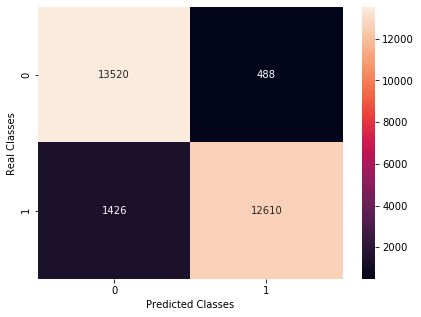

In [204]:
from sklearn.metrics import confusion_matrix
print("CV confusion matrix")
conf_matrix= pd.DataFrame(confusion_matrix(y_cv,cv_new_pred),range(2),range(2))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,2)
sns.heatmap(conf_matrix,annot=True,ax=ax,fmt='g')
plt.ylabel('Real Classes')
plt.xlabel('Predicted Classes')
plt.show()

<b>Looking at the above confusion matrix we see that there are a large number of false negatives and since its a  medical application we never want to falsely predict that the person is not affected by a disease rather it is okay to tell a person that he has a disease and let him take a second opinion, hence I would mind more false positives than false negatives.</b>

<h3>Changing the threshold value of classification to 0.4 so that we get a better tradeoff between fp and fn:</h3>

CV confusion matrix


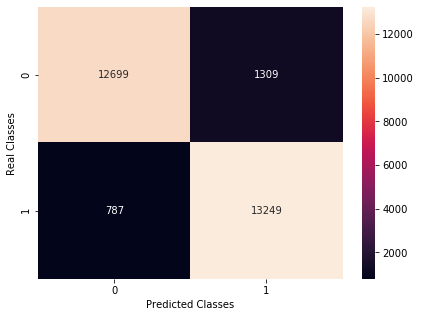

In [208]:
cv_new_pred=[]
for i in cv_probs:
    if i>0.4:
        cv_new_pred.append(1)
    else:
        cv_new_pred.append(0)
print("CV confusion matrix")
conf_matrix= pd.DataFrame(confusion_matrix(y_cv,cv_new_pred),range(2),range(2))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,2)
sns.heatmap(conf_matrix,annot=True,ax=ax,fmt='g')
plt.ylabel('Real Classes')
plt.xlabel('Predicted Classes')
plt.show()  

<b>The above confusion matrix shows us that by having a threshold value of 0.4 we are doing much better for this application since we are okay with having more number of false positives than false negatives. This is a business decision that we have made to change the threshold which would be better for this application.</b>

<h1>Test data Preprocessing and testing on test set:</h1>

In [209]:
def preprocess_test_set(test_data,cv,feature_freq_names):
    ls_without_priors=[]
    with open('test.txt') as f:
     for line in f:
        ls_without_priors.append(json.loads(line))
    age=[]
    for i in range(len(ls_without_priors)):
        age.append(2017-int(ls_without_priors[i]['bday'].split('-')[0]))
    df = pd.DataFrame({'Age':age})
    str_rep_of_resources=[]
    for i in range(len(ls_without_priors)):
        m=ls_without_priors[i]['resources']
        temp_s=''
        for j in m:
            temp_s+=' '.join(m[j])
            temp_s+=' '
            temp_s=re.sub(' +', ' ', temp_s)
        str_rep_of_resources.append(temp_s)
    cv_fit=cv.transform(str_rep_of_resources)
    resources_freq=cv_fit.toarray()
    df_resources_freq=pd.DataFrame(resources_freq)
    df_resources_freq.columns=feature_freq_names
    list_of_tests=[]
    for i in range(len(ls_without_priors)):
        test_list=[]
        test_code=set()
        dici={}
        m = ls_without_priors[i]['observations']
        for k in m:

            for x in m[k]:
                if x['code'] not in dici:
                    k_split=k.split('-')
                    k_time_obj=datetime.date(int(k_split[0]),int(k_split[1]),int(k_split[2]))
                    dici[x['code']]=[k_time_obj]
                elif x['code'] in dici:
                    k_split=k.split('-')
                    k_time_obj=datetime.date(int(k_split[0]),int(k_split[1]),int(k_split[2]))
                    dici[x['code']]+=[k_time_obj]
        list_of_tests.append(dici)
    for i in list_of_tests:
        for j in i:
            a=sorted(i[j])
            i[j]=a[-1]  
    new_list_of_tests = [] 
    for i in range(len(list_of_tests)):
        test={}
        for key, value in list_of_tests[i].items(): 
           if value in test: 
               test[value].append(key) 
           else: 
               test[value]=[key] 
        new_list_of_tests.append(test)

    feati=[]
    for i in range(len(new_list_of_tests)):
        cd=0
        for j in new_list_of_tests[i]:
            
            for m in new_list_of_tests[i][j]:
                if m=='loinc_4548-4':
                    r=ls_without_priors[i]['observations'][j.strftime('%Y-%m-%d')]
                    for q in r:
                        if q['code']=='loinc_4548-4':
                            if q['interpretation']=='H':
                                feati+=[1]
                                cd=1
                            else:
                                feati+=[0]
                                cd=1
                        if cd==1:
                            break
                if cd==1:
                    break
            if cd==1:
                    break
        if cd!=1:
                feati+=[0]

    df_interpret=pd.Series(feati)
    diabetes_icd_imp=df_resources_freq[['cpt_99232','icd10_i25','icd10_j96','icd10_e78','icd10_j44','icd10_i50','icd10_n18','cpt_83036']]
    diab_feat_imp=diabetes_icd_imp.sum(axis=1)
    diab_feat_imp.columns=['sum_of_imp_resources']
    final_features=pd.concat([df['Age'],df_interpret,df_resources_freq['icd10_i10'],df_resources_freq['icd10_e11'],diab_feat_imp],axis=1)
    predictions=clf.predict(final_features)
    predictions_probs=clf.predict_proba(final_features)[:,1]
    
    with open('prashanth_dm2_solution.csv', 'a') as file:
            ct=0
            writer = csv.writer(file)
            writer.writerow(['patient_id','dm2_prob'])
            for i in range(len(ls_without_priors)):
                writer.writerow([ls_without_priors[i]['patient_id'],predictions_probs[ct]])
                ct+=1
        
    
    
    
    
    
    
    return predictions,predictions_probs
                            
                        
op,predis=preprocess_test_set('test.txt',cv,feature_freq_names)
df=pd.read_csv('prashanth_dm2_solution.csv')
print(df.head(10))

  patient_id             dm2_prob
0      pat_1   0.2951823911315482
1      pat_2  0.38658285274904036
2      pat_4  0.27314622248737047
3      pat_8  0.27747051126826133
4     pat_11  0.18584597996556518
5     pat_17  0.10645579767898171
6     pat_18  0.15525364907500588
7     pat_19   0.1024021043546173
8     pat_20   0.2246428555125333
9     pat_23  0.30460711841754273


## 5. A short write-up (2-3 paragraph) of your approach. Be sure to include the following:
### - Top 5 most important features for predicting diabetes - have a rationale for why you think these are most important
### - Briefly describe the model you used for training
### - Explain how you optimized your model, and what performance metrics you optimized for
### -How did you prevent overfitting?

## Top 5 most important features for predicting diabetes:

1) The most important feature I could observe after deep exploration of the data was the feature called icd10_e11 . This feature was extracted from the resources key under the record of each patient.The reason why I think this feature is the most important is because it acted as a direct signal to let me know if a person is affected by type-II diabetes or not. This is because icd10_e11 is actually the code which indicates type-II diabetes in medical literature hence acting sort of like a label by itself.

The above fact can also be proven by looking at the coefficients of the line which seperates the classes in logistic regression. We can interpret this fact by looking at the coefficients. We can very well observe below that the fourth number below corresponds to the feature icd10_e11 and this is the largest number of all thereby proving that its the most important feature.

In [192]:
clf.coef_

array([[0.02167449, 0.13493343, 0.03281268, 1.34845179, 0.01319281]])

2) The 2nd most indicative feature to me was the feature which was obtained from the observations key of each patients record. This was the interpreatation of the lab test 'loinc_4548-4' .This was encoded into bag of words and this being high turned out to be a very important feature. Only the fact that it was high or not was retained in a single column of vector. The scientific reason why this is so important is because this indicates the level of haemogloibin. Haemoglobin is a compound which directly affects the blood glucose level because it carries glucose molecules in it and therefore blood glucose level increase leads to the condition of diabetes. This again can be observed from the output of coefficients above where the second number is the second largest.

3) The next most important feature that I could see from exploring the data was the age of a person.This feature was designed using the bithday dates of each patient. The age of a person had a good correlation with the fact that a person was affected by diabetes or not. This is because a person above the age 60 is more likely to get affected by type-II diabetes and a person below the age 20 was less likely to be affected by this. This was observed by observing the distribution pertaining to both the classes.

4)Another very important feature that I found from the dataset was the code icd10_i10 which relates to hypertension in medical literature. This again influences the fact that a person will have diabetes or not by a large factor. A paper states that there is a very large relation between hypertension and diabetes.
<a href="https://care.diabetesjournals.org/content/40/9/1273">https://care.diabetesjournals.org/content/40/9/1273</a>

5)Another important feature that I personally engineered was a combination of multiple codes indicating various health conditions in medical literature
('cpt_99232','icd10_i25','icd10_j96','icd10_e78','icd10_j44','icd10_i50','icd10_n18','cpt_83036'). This was again obtained from the features key in the dataset. These were the most imporatant features indicated by SelectKBest but they did not have any significant effect when individually added to the model but they ended up having a very significant effect when added up together.  The sum was taken after bow encoding. The distribution of the sum of these features was observed and it indicated a significant difference in the way it was distributed for patients with diabetes and patients without diabetes.

## Model used for training:

Why was logistic regression chosen?

The model that the data was finally trained on was logistic regression model. A decision tree was also tried out and a decision tree with a depth of 4 gave the same exact performance of logistic regression. Since Logistic Regression gave results on par with decision tree it was chosen to model the data rather than decision trees. The reason for this being logistic regression is a simpler model and if it gives such a good performance it is sort of indicative that the data is Linearly seperable.

Specifications of the model:

Logistic regression is a simple classification algorithm to seperate linearly seperable data. The data that it was trained on had about 5 features hence we had to train 5 parameters for the model. Also L2 REGULARISATION was used.

## Optimisation of the Model:

I personally believe that one of the most important thing for a data scientist is exploring at the data  and gathering the best features from it. Hence I spent most of my initial time engineering the features and making sure to get the best out of them. Most of the important features was explored using various plots and the best were retained.

The model was later
optimized for best performance using a single fold cross-validation. We just had one parameter to tune that is the coefficient of the regularisation term. A linear search across different values of the regularisation parameter was done and we obtained the best regularisation parameter value to be 10^-4. The metric used to evaluate this was PRAUC(same as average precision score). The precision-recall curve for different values of the hyperparameter was also plotted and then the best model was choosen by looking at the metrics and the curve and taking into consideration the bias-variance tradeoff. The threshold value of the model was chosen to be 0.4. This was done because with a standard threshold of 0.5 we were getting more false negatives than false positives. In a medical application we are always okay with a person being falsely clssified to have a disease because in that case he can always take a second opinion but he/she cannot be falsely diagnosed with having no disease since that could be really dangerous to the person. By changing threshold we had slightly more false positives but we reduced the false negatives by a lot.</b>

## How overfitting was prevented?

Overfitting here was prevented using L2-regularisation. I searched linearly across various values of the regularisation parameter and the best value was obtained using cross-validation. The best value was found to be 10^-4.